In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import seaborn as sns
from survAux import *
import pyroc
from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.metrics import confusion_matrix
import pickle

plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_3474333/3139812724.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# Example making Aalen Johansen curve

In [3]:
vte = pd.read_csv('../data/discovery.csv')
vte2 = pd.read_csv('../data/validation.csv')
resbio_msk = pd.read_csv('../data/generalizability_msk.csv')
sydney = pd.read_csv('../data/generalizability_sydney.csv')

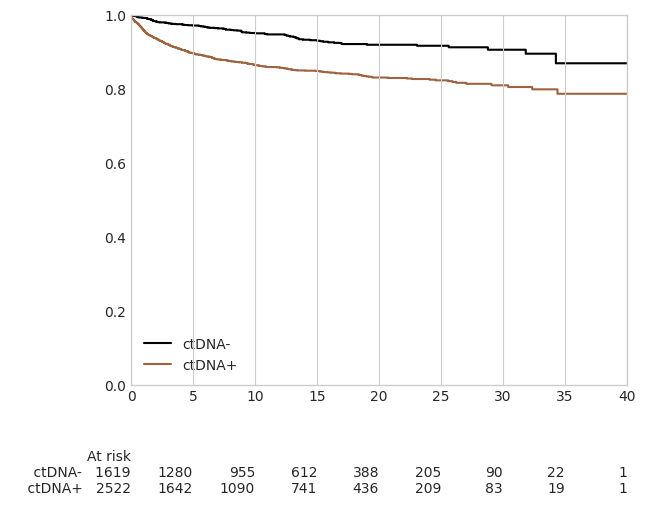

In [17]:
from lifelines import AalenJohansenFitter
from lifelines.plotting import add_at_risk_counts

def plotAJF(df,label,ax,**kwargs):
    stopcol='stop'
    startcol='start'
    if 'stop' in kwargs:
        stopcol=kwargs['stop']
    if 'start' in kwargs:
        startcol=kwargs['start']
        
    if not startcol in df.columns:
        df[startcol]=0
        
    df.loc[df[stopcol]<=df[startcol],stopcol] = df[df[stopcol]<=df[startcol]][startcol]+1
    
    aj1 = AalenJohansenFitter()
    aj1.fit(durations=df[stopcol]/daysinmo, 
                     event_observed=df['CAT_DEATH_ENDPT'], 
                     event_of_interest=1,label=label, entry=df[startcol]/daysinmo)
    ax.step(aj1.cumulative_density_.index,1-aj1.cumulative_density_['CIF_1'],label=label)
    
    return aj1

fig, ax=plt.subplots()
ax.set_prop_cycle(color=[plt.cm.copper(i) for i in np.linspace(0, 1, 3)])
aj1 = plotAJF(vte[~vte['+ctDNA']],'ctDNA-',ax)
aj2 = plotAJF(vte[vte['+ctDNA']],'ctDNA+',ax)
ax.grid(visible=False)
ax.set_ylim(0,1)
ax.set_xlim(0,40)
add_at_risk_counts(aj1, aj2, ax=ax, rows_to_show=['At risk'])
ax.legend()

fig.savefig('ctDNA_CAT_discovery.pdf', format='pdf')

# plots from R

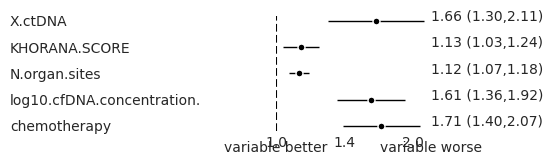

In [4]:
# NOTE meant to be run after Competing Risks R notebook
df = pd.read_csv('multivariate_HR_example.csv',index_col=0)
HRs = pd.Series(list(zip(df['exp(coef)'], 
                         df['2.5%'], 
                         df['97.5%'])),
               index = df.index)
myForest(HRs,'variable worse','variable better','multivariate_HR_example.pdf',(2,1.5))

# use RSFs to make predictions

In [15]:
# NOTE: meant to be run AFTER run_rsf_vte.py
# *** models are too large to store on github so must be trained locally ***

with open('models/LB+.pkl', 'rb') as f:
    rf = pickle.load(f)

vte2 = pd.read_csv('../data/validation.csv') # <--substitute with your file (must contain lbplus_cols)

# add gene columns
xs_common_genes = pd.read_csv('common_gene_list.txt')
def queryOncogenicMutations(s, g):
    tok = s.split(';')
    if len(tok)>0:
        return sum([g==t.split(' ')[0] for t in tok])>0
    return False
for g in list(xs_common_genes['Gene']):
    vte2[g]=vte2['ONCOGENIC_MUTATIONS'].fillna('').apply(lambda x: queryOncogenicMutations(x, g))
    
common_cancers = ['Non-Small Cell Lung Cancer',
 'Breast Cancer',
 'Pancreatic Cancer',
 'Melanoma',
 'Prostate Cancer',
 'Bladder Cancer',
 'Esophagogastric Cancer',
 'Hepatobiliary Cancer',
 'Colorectal Cancer']

lbplus_cols = list(xs_common_genes['Gene'])+['+ctDNA','log10(max VAF)','log10(cfDNA concentration)']+common_cancers+['chemotherapy']

preds = rf.predict(vte2[lbplus_cols])

# comparing RSF with vs without competing risks

In [3]:
riskscores_deathcensor = pd.read_csv('vte_riskscores_validation.csv')
riskscores_cmprsk = pd.read_csv('vte_riskscores_validation_cmprsk.csv')

Text(0.5, 1.0, 'risk scores in validation cohort')

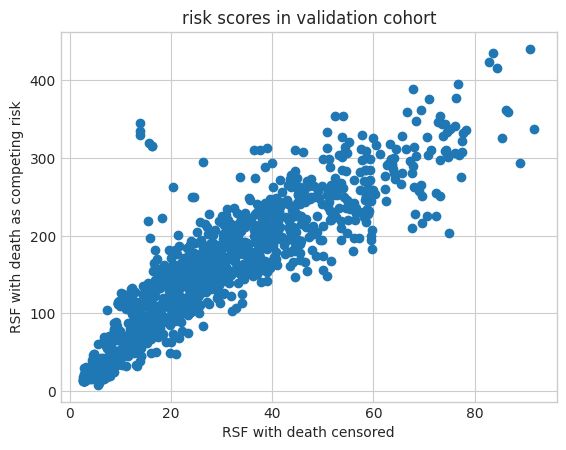

In [5]:
plt.scatter(riskscores_deathcensor['LB+'],
            riskscores_cmprsk['event.1'])
plt.xlabel('RSF with death censored')
plt.ylabel('RSF with death as competing risk')
plt.title('risk scores in validation cohort')

Text(0.5, 1.0, 'risk scores for two endpoints in validation cohort with competing risks RSF')

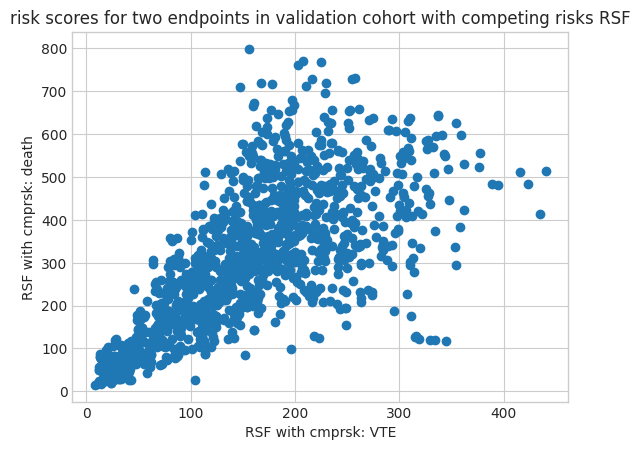

In [7]:
plt.scatter(riskscores_cmprsk['event.1'],
           riskscores_cmprsk['event.2'])
plt.xlabel('RSF with cmprsk: VTE')
plt.ylabel('RSF with cmprsk: death')
plt.title('risk scores for two endpoints in validation cohort with competing risks RSF')